<img align="right" src="https://github.com/eo2cube/eo2cube_book/blob/7880672deff906b41f993c856fe1a7eb38ed5b3a/images/banner_siegel.png?raw=true" style="width:1000px;">

# Parallel processing with Dask

## Description
This notebook builds upon the notebook [07_basic_analysis](07_basic_analysis.ipynb). In that notebook, we presented a sample workflow for spatial data processing. In this notebook, we will perform a partially similar workflow. The main difference is that we will perform the calculation using `Dask`. The following workflow will be applied:
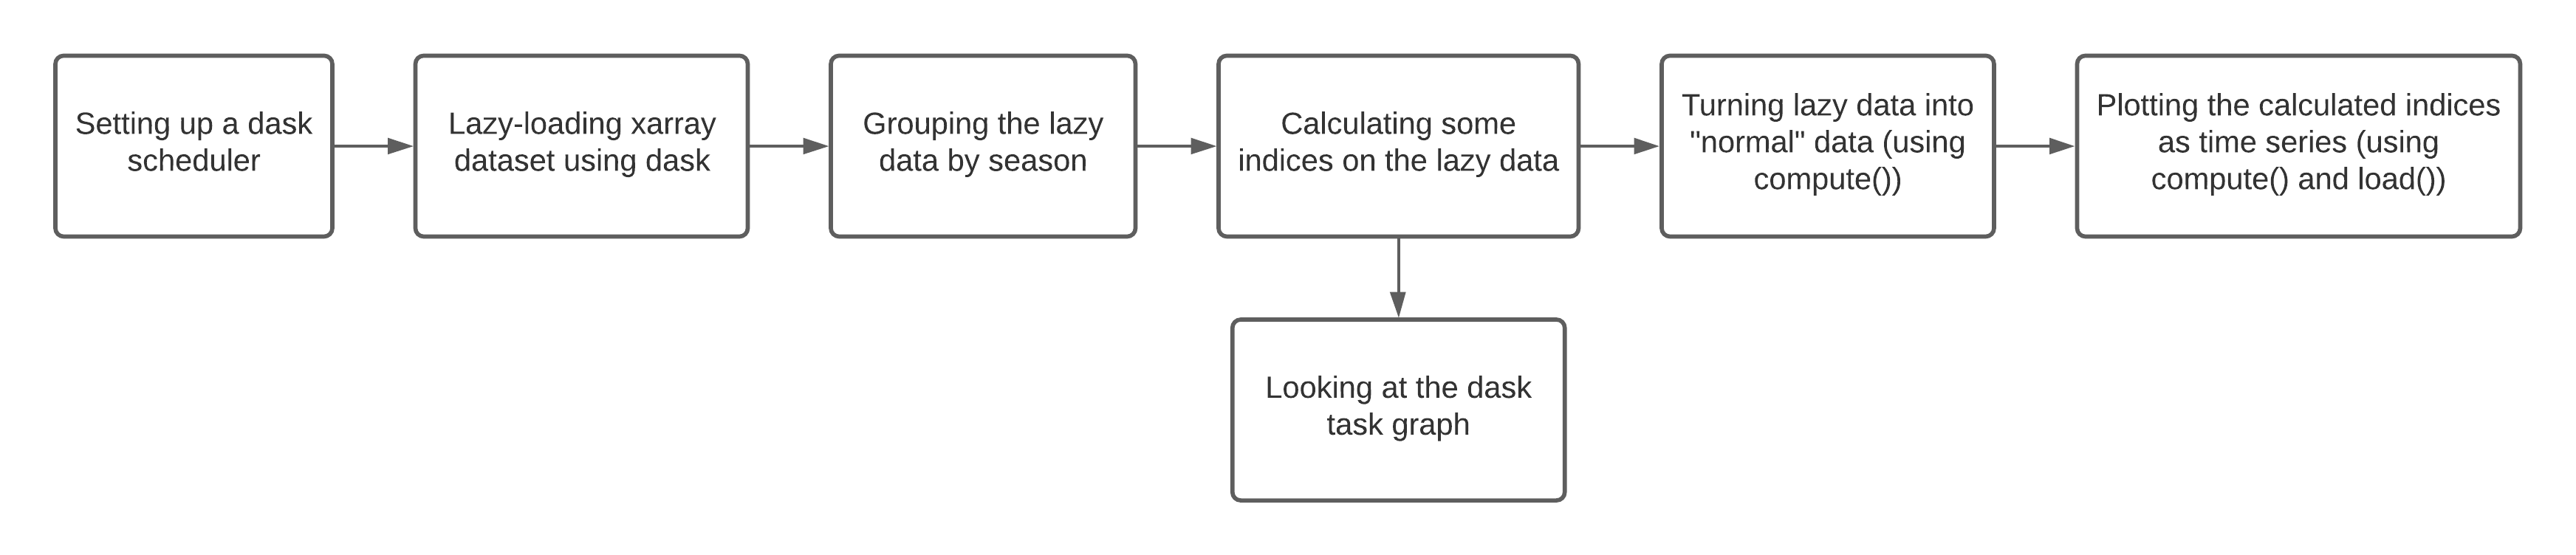

## What is Dask?
[Dask](https://dask.org/) is a library for parallel computing. It can be used to scale Pandas, NumPy, and Scikit-Learn workflows. Initially, datasets created with those libraries can only be scaled on a single machine. Dask internally uses the structures of Pandas, Numpy, and Scikit-Learn. Thus, if you are familiar with those libraries, it will be easy to transform your "old" code into a new, scalable Dask-version of it. <br>
In this notebook, we will mainly work with [daskArray](https://docs.dask.org/en/latest/array.html), the dask-equivalent of NumPy ndarray.

## Package import and datacube connection

First of all, we start with importing all the needed packages for our analysis.<br>
Most of the packages have already been introduced in the previous notebooks. The newly introduced package here is Dask.

In [1]:
!pip install graphviz
!pip install deafrica_tools

In [2]:
import datacube

# dask
import dask
from dask.distributed import Client
from deafrica_tools.dask import create_local_dask_cluster # digital earth africa datacube package, which already includes Dask functionality.
# plotting
import graphviz
import seaborn as sns

# images
import matplotlib.pyplot as plt
import pandas as pd
from odc.ui import with_ui_cbk

# vector
import geopandas as gpd

Connecting to the datacube

In [3]:
dc = datacube.Datacube(app = '08_parallel_processing_with_dask')

## Dask Schedulers
### (Single machine scheduler vs. Distributed scheduler)
One of the significant features of Dask is that it can take advantage of multiple CPU cores (cluster) to speed up computations, which is known as distributed computing. This is good for situations where you need to do many calculations on large datasets. <br>

We are using the distributed scheduler for the following analysis since we are working on a datacube.<br>

### Setting up Dask.distributed 
<span style='color:red'>**for me not working**</span> 

To start the Dask Client, we use the Dask-plugin within the Phenocube.
To use it, click on the orange Dask symbol on the left side of the window. Then click on the "+ New" Button. A new LocalCluster is created. <br>By clicking on the "Scale" button, the Client can be scaled (i.e. reducing the number of workers). <br>
Now, drag and drop the cluster into this code and reduce the number of workers to 2.

In [4]:
#from dask.distributed import Client

#client = Client("tcp://127.0.0.1:41935")
#client

### Set up a Dask cluster and enabling Dask

To set up distributed computing with Dask, we need to first set up a Dask client using the function below:

In [5]:
create_local_dask_cluster()

<Client: 'tcp://127.0.0.1:38605' processes=1 threads=80, memory=1.42 TiB>

The output displays the `Client` and the `Cluster` information. We are most interested in the hyperlink after the Dashboard: heading, which should look like /user/<username>/proxy/some-numbers/status, where <username> is your username for the Saldicub.

This link allows us to view how many computations we are running now are progressing. There are two ways to view the dashboard: 1. Click the link to open a new tab in our browser 2. Set up the dashboard inside the eo2cube Environment.

We will now cover how to do the second option.

### Dask dashboard in eo2cube

1. On the left-hand menu bar, click the Dask icon <img src="../../additional_data/dask_img.png" style="width:20px; height:22px;" >.


2. Copy and paste the `Dashboard hyperlink` from the Client output in the `DASK DASHBOARD URL` text box. If the url is valid, the buttons should go from grey to orange.


## Loading the data using dask
In the following, the data is loaded.
For loading data with dask, you just add the "dask_chunks"-parameter. <br>
This looks like this:

In [6]:
# Load Data
ds = dc.load(
            product= "s2_c1_l2a",
            x= (9.96 ,10.0),
             y= (49.75, 49.78),
             time= ("2021-01-01", "2021-12-31"),
             output_crs = "EPSG:32734",
            measurements = ["red","green","blue", "nir","nir08","rededge2", "scl"],
            resolution = (-30,30),
            group_by = "solar_day",
             dask_chunks={"time": 1, 'x': 5000, 'y': 5000}) 
             

To understand what we have done here, let's first look at the dataset we loaded.

In [7]:
ds

<xarray.Dataset>
Dimensions:      (time: 145, y: 126, x: 113)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-01T10:23:29.024000 ... 2021-12...
  * y            (y) float64 1.557e+07 1.557e+07 ... 1.557e+07 1.557e+07
  * x            (x) float64 -2.945e+05 -2.944e+05 ... -2.911e+05 -2.911e+05
    spatial_ref  int32 32734
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    nir08        (time, y, x) uint16 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    rededge2     (time, y, x) uint16 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    scl          (time, y, x) uint8 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
Attributes:
    crs:           EPSG:32734
    grid_mapping:  spatial_ref

You see that the xarray.Dataset consists of multiple [dask.array](https://docs.dask.org/en/latest/array.html) objects but we cannot see any values inside our data. <br>
This type of data is called "lazy data" as it is not loaded properly but in a "lazy" way without evaluated data values.

## Dask Chunks
The parameter added to the dc.load() command is called "dask_chunks". It defines how many parts of our original dataset will be split. As described in the previous notebooks, the dc.load() command usually produces a xarray dataset consisting of integer values.<br>
In our case, the dataset is split into smaller chunks. Since the data we are interested in is three-dimensional, we also need to provide three dimensions for subdividing the data. <br>
The chunk size of the dask.arrays scales according to the provided values within the "dask_chunks" parameter.
<br>
In the following, we will visualize the lazy-loaded data for the red band to get a better feeling about our data type.


In [8]:
# visualizing the dask chunks
ds.red.data

dask.array<dc_load_red, shape=(145, 126, 113), dtype=uint16, chunksize=(1, 126, 113), chunktype=numpy.ndarray>

Here, the red band of our lazy dataset is shown. Our data is divided into multiple chunks, each having the size we defined within the "dask_chunks" parameter in the dc.load() function. <br>
Looking at the memory size of the chunks compared to the complete array, the motivation for using dask becomes clear. Especially when working with large amounts of data, splitting the data into smaller chunks enables computations that would crash the cube environment when calculated over the complete array.

## Lazy operations
When working with large amounts of data, it makes sense to postpone loading the data as far back as possible. To do so, we can perform operations on lazy data directly, without loading its values. <br>
When we want to do a computation on lazy data, it makes sense to chain operations together and calculate the result right at the end (with the compute() function). <br>
In the [previous notebook](07_basic_analysis.ipynb), we did some basic analysis. Now, this analysis will be repeated but using dask. As already mentioned, the code will not differ a lot since dask is built on NumPy. The main difference is that the calculation is performed in a "lazy" way in this case. Thus, the resulting values are not calculated directly but will be on-demand (using the compute() function).<br>

### Grouping the data by month and extracting the mean
We start with grouping our data by season and calculating the mean value for each pixel. <br>
As you may remember, `groupby('time.season')`creates four groups: 'DJF'(Dec, Jan, Feb), 'MAM' (Mar, Apr, May), 'JJA' (Jun, Jul, Aug) and 'SON' (Sep, Oct, Nov) <br>
**NOTE**: In [previous notebook](07_basic_analysis.ipynb), we calculated the median on the seasonal values. Here we calculate the mean because the  `median()` function is not implemented on dask arrays.

In [9]:
# Group by Season and Calculate the seasonal Median.
ds_grp_dask = ds.where(ds.scl <= 6).groupby('time.season').mean()

print(ds_grp_dask)

<xarray.Dataset>
Dimensions:      (season: 4, y: 126, x: 113)
Coordinates:
  * y            (y) float64 1.557e+07 1.557e+07 ... 1.557e+07 1.557e+07
  * x            (x) float64 -2.945e+05 -2.944e+05 ... -2.911e+05 -2.911e+05
    spatial_ref  int32 32734
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    red          (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    green        (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    blue         (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    nir          (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    nir08        (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    rededge2     (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    scl          (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
Attributes:
    crs:  

The data is now grouped into monthly timesteps but still in dask.array-format as it is not computed yet.

### Calculating indices on grouped, lazy-loaded data

In [10]:
#NDVI
ndvi = (ds_grp_dask.nir - ds_grp_dask.red)/(ds_grp_dask.nir+ds_grp_dask.red)

# Tasseled Cap Wetness
wet = 0.1509*ds_grp_dask.blue + 0.1973*ds_grp_dask.green + 0.3279*ds_grp_dask.red + 0.3406*ds_grp_dask.nir - 0.711211 - 0.457212
# Tasseled Cap Green Vegetation
gvi = -0.2848*ds_grp_dask.blue-0.2435*ds_grp_dask.green-0.5436*ds_grp_dask.red + 0.7243*ds_grp_dask.nir + 0.084011 - 0.180012
# Tasseled Cap Soil Brightness
sbi = 0.332*ds_grp_dask.green + 0.603*ds_grp_dask.red + 0.675*ds_grp_dask.rededge2 + 0.262*ds_grp_dask.nir08

After creating them, we need to add the calculated indices to our Dask dataset.

In [11]:
ds_grp_dask['ndvi']=ndvi
ds_grp_dask['wet']=wet
ds_grp_dask['gvi']=gvi
ds_grp_dask['sbi']=sbi
ds_grp_dask

<xarray.Dataset>
Dimensions:      (season: 4, y: 126, x: 113)
Coordinates:
  * y            (y) float64 1.557e+07 1.557e+07 ... 1.557e+07 1.557e+07
  * x            (x) float64 -2.945e+05 -2.944e+05 ... -2.911e+05 -2.911e+05
    spatial_ref  int32 32734
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    red          (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    green        (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    blue         (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    nir          (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    nir08        (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    rededge2     (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    scl          (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    ndvi         (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    wet          (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    gvi          (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    sbi          (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
Attributes:
    crs:           EPSG:32734
    grid_mapping:  spatial_ref

We now calculated some indices based on lazy-loaded data. Since we have not used the compute() function, the indices are lazy-loaded dask.arrays as well.

## Task Graph
To get a better feeling for what happens when we chain tasks in dask, we now will have a look at the task graph using the visualize()function. This produces a graph that shows all the tasks that dask needs to execute.
If the graph is too large, an error occurs. In this case, look at the working folder for a .png file. It should contain the produced graph. 
If the graph opens within the notebook, double-clicking on it will enlarge it. 
<br>
<br>
**Note:** The visualization of the graph might take some time, depending on the amount of data.

In [12]:
ds_grp_dask.red.data.visualize()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.554424 to fit


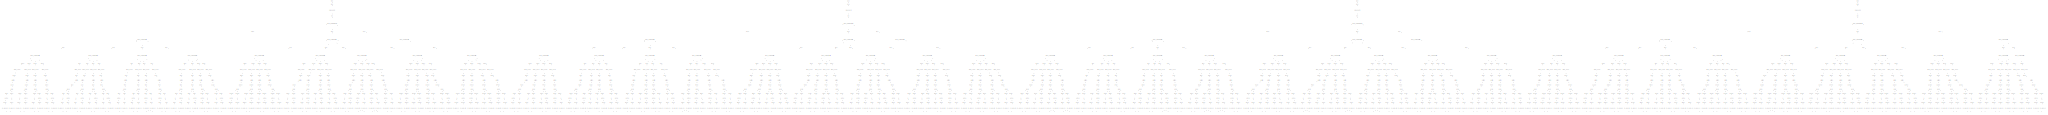

In [13]:
ds_grp_dask.red.data.visualize(filename='graph.svg')

## Loading/ computing lazy data

### compute()

Lazy Dask arrays do not evaluate (e.g., contain actual values) until we initiate their calculation. The `compute()`-function triggers such an evaluation.<br>
It is important to note that `compute()`writes its results into memory. So only use it if the results will fit in it. If they are too large, it is possible to write them to disk directly. 
For dask Arrays the `to_hdf5()`command can be used (`my_dask_array.to_hdf5("myfile.hdf5")`) to do so. <br>
Running `compute()` might take some time, depending on the size of your `DataArray` or `Dataset`.

In the following case, we will use the compute function, to visualize the calculated indices as a timeseries. <br>
The same has already been done in Notebook 7. The only difference is, that in this case we compute() the lazy data first.

In [14]:
ds_grp_dask_computed = ds_grp_dask.compute()
ds_grp_dask_computed

/opt/conda/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


/opt/conda/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


2024-01-23 16:18:44,574 - distributed.worker.state_machine - ERROR - Unhandled exception in async instruction for <Task finished name="execute(('getitem-where-mean_chunk-575ebfbb38f19a5833dd2491b6a00941', 33, 0, 0))" coro=<Worker.execute() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/worker_state_machine.py:3615> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker_state_machine.py", line 3638, in _finish_async_instruction
    stim = task.result()
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker_state_machine.py", line 3618, in wrapper
    return await func(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 206, in wrapper
    return await method(self, *args, **kwargs)  # type: ignore
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2278, in execute
    result = await run_in_executor_with_context

2024-01-23 16:18:45,057 - distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

2024-01-23 16:18:46,932 - distributed.nanny - WARNING - Restarting worker


As you see, the values of the Data variables now have changed from `dask.array`to actual `int16`values. This data can now for example be plotted. <br>
**Note:** When you try to plot lazy loaded data directly (without applying the `compute()`function beforehand) the data will be computed automatically. Thus, plotting lazy loaded data will take some time due to the inherent computation process. <br>

### Plot Time Series
After computing the lazy data, we will now plot the ndvi, wet, gvi and sbi values for each season.

Text(0.5, 1.02, 'Seasonal Mean 2019')

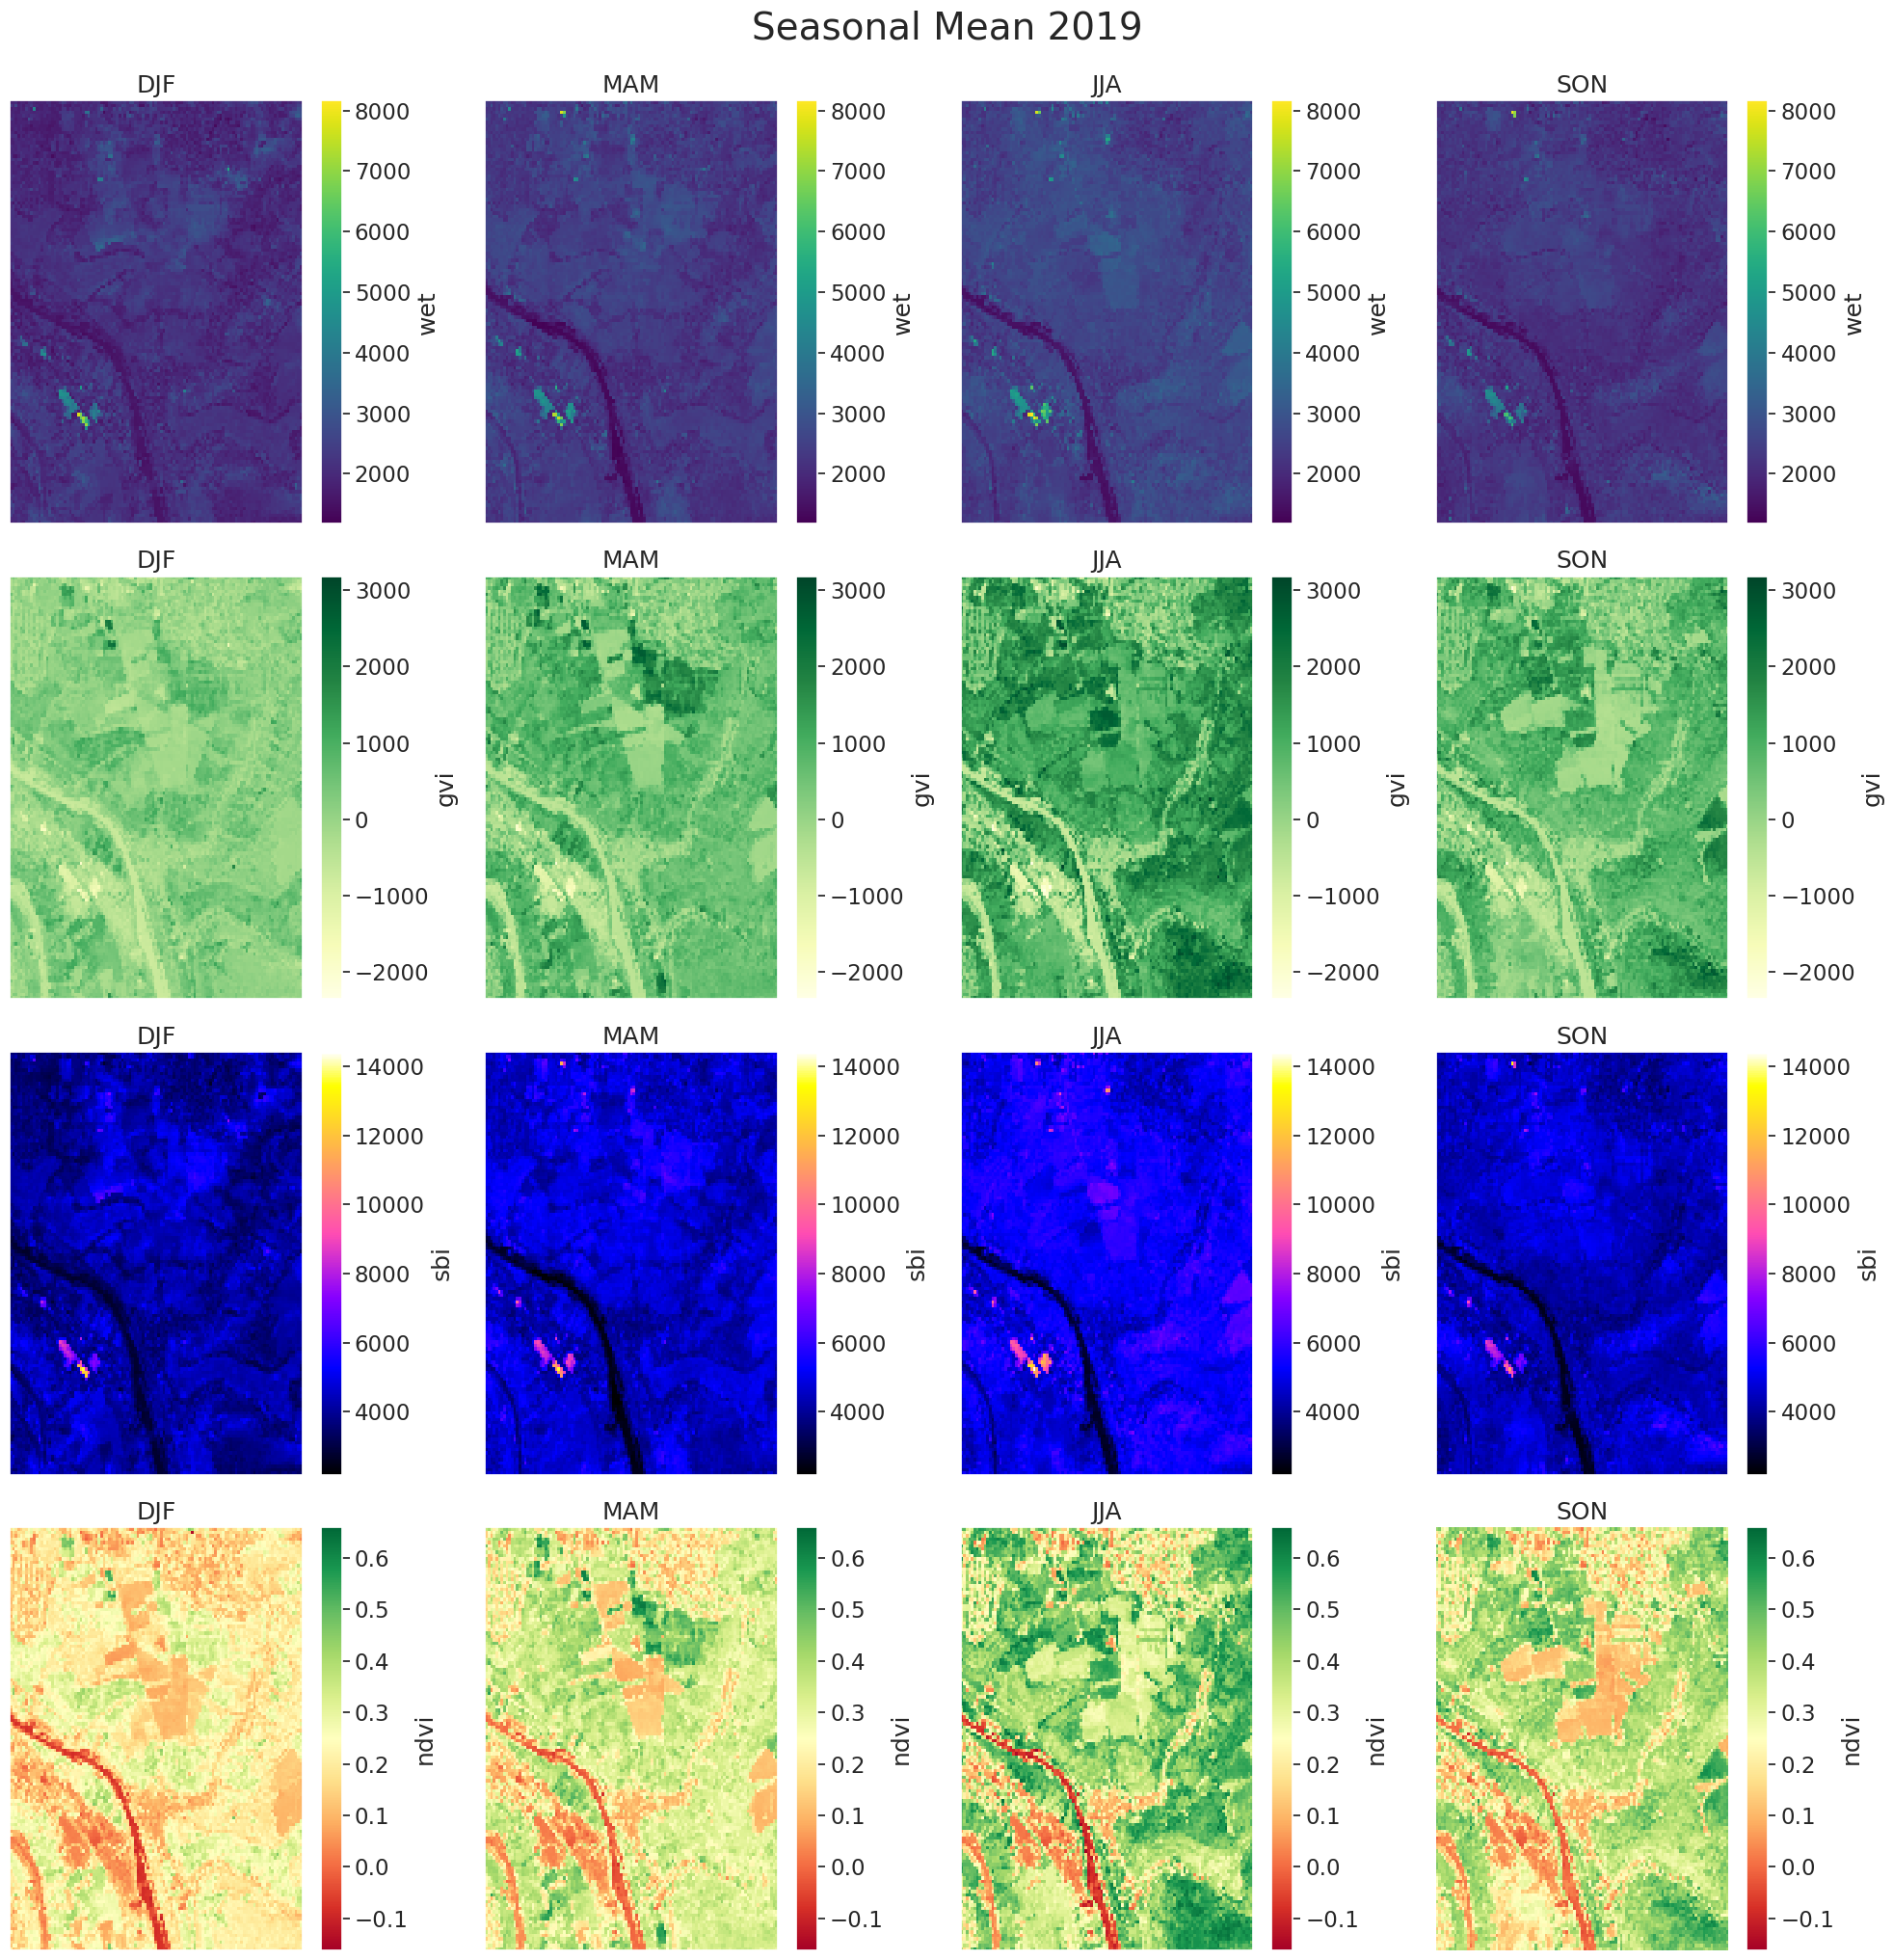

In [15]:
mylist = ["DJF", "MAM", "JJA", "SON"] #arrange seasons into our list
c = ['viridis','YlGn','gnuplot2','RdYlGn'] #the list of color maps

sns.set(font_scale=1.5) #scale the texts in plot to 1.5
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20,20)) #plot subplots

for i, sea in enumerate(mylist):
    ds_grp_dask_computed['wet'].sel(season=sea).plot(ax=axes[0,i], vmin=ds_grp_dask_computed.wet.min(), vmax=ds_grp_dask_computed.wet.max(), cmap=c[0], robust=True)                                      
    ds_grp_dask_computed['gvi'].sel(season=sea).plot(ax=axes[1,i], vmin=ds_grp_dask_computed.gvi.min(), vmax=ds_grp_dask_computed.gvi.max(), cmap=c[1], robust=True)
    ds_grp_dask_computed['sbi'].sel(season=sea).plot(ax=axes[2,i], vmin=ds_grp_dask_computed.sbi.min(), vmax=ds_grp_dask_computed.sbi.max(), cmap=c[2], robust=True)
    ds_grp_dask_computed['ndvi'].sel(season=sea).plot(ax=axes[3,i], vmin=ds_grp_dask_computed.ndvi.min(), vmax=ds_grp_dask_computed.ndvi.max(), cmap=c[3], robust=True)
    
for i, ax in enumerate(axes.flatten()):
    ax.set_title(mylist[i%4]) #plot subtitles
    
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([]) #empty x ticks
    ax.axes.get_yaxis().set_ticklabels([]) #empty y ticks
    ax.set_xlabel('') #empty x label
    ax.set_ylabel('') #empty y label
    
plt.axis("off") #remove all axis
plt.tight_layout() #adjust excessive padding
fig.suptitle('Seasonal Mean 2019', fontsize=28, y=1.02) #main plot title

### load()

Dask also provides the `load()`function as a second version to calculate lazy-loaded data. When using the load() command, we do not only get the calulated data as a return but also change the values in the lazy-loaded dataset to its calculated values. This is not true for the `compute()`command.

In [16]:
# original lazy-loaded data
ds_grp_dask

<xarray.Dataset>
Dimensions:      (season: 4, y: 126, x: 113)
Coordinates:
  * y            (y) float64 1.557e+07 1.557e+07 ... 1.557e+07 1.557e+07
  * x            (x) float64 -2.945e+05 -2.944e+05 ... -2.911e+05 -2.911e+05
    spatial_ref  int32 32734
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    red          (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    green        (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    blue         (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    nir          (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    nir08        (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    rededge2     (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    scl          (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    ndvi         (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    wet          (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    gvi          (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    sbi          (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
Attributes:
    crs:           EPSG:32734
    grid_mapping:  spatial_ref

In [17]:
# calculating the gvi values using the compute() function
gvi_compute = ds_grp_dask.gvi.compute()

# and plotting the original data again
ds_grp_dask

<xarray.Dataset>
Dimensions:      (season: 4, y: 126, x: 113)
Coordinates:
  * y            (y) float64 1.557e+07 1.557e+07 ... 1.557e+07 1.557e+07
  * x            (x) float64 -2.945e+05 -2.944e+05 ... -2.911e+05 -2.911e+05
    spatial_ref  int32 32734
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    red          (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    green        (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    blue         (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    nir          (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    nir08        (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    rededge2     (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    scl          (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    ndvi         (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    wet          (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    gvi          (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
    sbi          (season, y, x) float32 dask.array<chunksize=(1, 126, 113), meta=np.ndarray>
Attributes:
    crs:           EPSG:32734
    grid_mapping:  spatial_ref

In [29]:
# calculating the gvi values using the load() function
gvi_load = ds_grp_dask.gvi.load()

# and plotting the original data again
ds_grp_dask

<xarray.Dataset>
Dimensions:      (y: 466, x: 699, season: 4)
Coordinates:
  * y            (y) float64 6.807e+06 6.807e+06 ... 6.802e+06 6.802e+06
  * x            (x) float64 8.718e+05 8.718e+05 ... 8.787e+05 8.788e+05
    spatial_ref  int32 32734
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    blue         (season, y, x) float64 dask.array<chunksize=(1, 466, 699), meta=np.ndarray>
    green        (season, y, x) float64 dask.array<chunksize=(1, 466, 699), meta=np.ndarray>
    red          (season, y, x) float64 dask.array<chunksize=(1, 466, 699), meta=np.ndarray>
    nir_1        (season, y, x) float64 dask.array<chunksize=(1, 466, 699), meta=np.ndarray>
    nir_2        (season, y, x) float64 dask.array<chunksize=(1, 466, 699), meta=np.ndarray>
    red_edge_2   (season, y, x) float64 dask.array<chunksize=(1, 466, 699), meta=np.ndarray>
    ndvi         (season, y, x) float64 dask.array<chunksize=(1, 466, 699), meta=np.ndarray>
    wet          (season, y, x) float64 dask.array<chunksize=(1, 466, 699), meta=np.ndarray>
    gvi          (season, y, x) float64 303.6 304.1 356.8 ... -152.3 -71.67
    sbi          (season, y, x) float64 dask.array<chunksize=(1, 466, 699), meta=np.ndarray>

## Further Information
For further information about Dask, please have a look at the [Dask webpage](https://docs.dask.org/en/latest/).

***

## Additional information

<font size="2">This notebook for the usage in the Open Data Cube entities of the [Department of Remote Sensing](http://remote-sensing.org/), [University of Wuerzburg](https://www.uni-wuerzburg.de/startseite/), is adapted from [Geoscience Australia](https://github.com/GeoscienceAustralia/dea-notebooks), published using the Apache License, Version 2.0. Thanks!</font>

https://doi.org/10.26186/145234 <br>

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.


**Contact:** If you would like to report an issue with this notebook, you can file one on [Github](https://github.com).

**Last modified:** January 2023